# Contents


**1. Load data and check data**

**2. Text Preprocessing**

**3. Data Relabelling Algorithm**

**4. Cutoff Analysis for speeches length**

In [35]:
import pandas as pd
import operator
from __future__ import print_function
import csv
import numpy as np
import pickle
import string
import re
import numpy as np
import scipy
import os
import collections
from tqdm import tqdm_notebook as tqdm
import warnings
warnings.filterwarnings('ignore')

#sklearn
from sklearn.model_selection import train_test_split

#nltk for nlp
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

#relabel model
#from relabel_model import RuleBasedStanceDetection

#plot
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('ggplot')

### 1. Load data and check data

**1.1 load data**

In [26]:
def read_data(data_path):
    '''
    read csv file
    input: your csv file location 
    output: DataFrame
    '''
    data = pd.read_csv(data_path,index_col=0)
    return data

In [27]:
data = read_data('../data/cleaned_data/data.csv')
data.head()

,support,text,volume_no,issue_no,page_range,person_id,full_name,party,chamber,title,tagged
0,1,"Mr. GRAYSON . Mr. Speaker, these statements an...",159,42,E357-E358,29284,Alan-nan-Grayson,D,H,Catching Up to 1968 Act of 2013,1
1,1,"Ms. GABBARD . Mr. Speaker, I rise today in str...",159,42,E362,46246,Tulsi-nan-Gabbard,D,H,Helping Heroes Fly Act,1
2,1,"Mr. FALEOMAVAEGA . Mr. Speaker, I want to shar...",159,42,E363-E364,19,Eni-F.H.-Faleomavaega,D,H,Non-Disparagement of Native American Persons o...,1
3,-1,"Mr. COHEN . Mr. Speaker, I rise today to share...",159,39,H1559,1762,Steve-nan-Cohen,D,H,Northern Route Approval Act,1
4,1,"Ms. JACKSON LEE . Mr. Speaker, in a few weeks,...",159,42,H1725,475,Sheila-nan-Jackson Lee,D,H,Child Gun Safety and Gun Access Prevention Act,1


**1.2 check data**

In [28]:
# define X, y to be the speeches and the speech label(if it has stance)
X, y = data['text'],data['tagged']
# check data before relabelling
y.value_counts()

-1    45351
 1     2077
Name: tagged, dtype: int64

In [29]:
def save_jpeg(path,name):
    fn = '%s.jpeg'%name
    plt.savefig(os.path.join(path,fn))

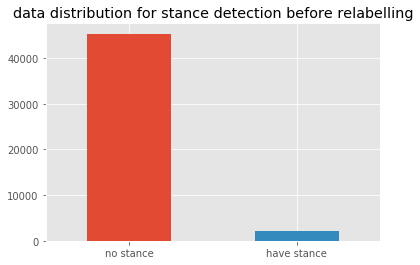

In [30]:
y1 = y.copy()
y1.replace({-1:'no stance',1:'have stance'},inplace=True)
y1.value_counts().plot.bar(rot=0)
plt.title('data distribution for stance detection before relabelling')
save_jpeg('../graphs','data distribution before relabelling')

**findings:** the data is extremely imbalanced

## 2. Test Preprocessing

** 2.1 regular text preprocessing**

In [ ]:
def tokenize_text(text):
    '''
    tokenization
    '''
    tokens = word_tokenize(text.lower())
    tokens = [token.strip() for token in tokens]
    return tokens

def remove_stopwords(text):
    '''
    remove stop words
    '''
    stop = list(set(stopwords.words('english')))
    tokens = tokenize_text(text)
    filtered_tokens = [token for token in tokens if token not in stop]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

def remove_special_characters(text):
    '''
    remove special characters: '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    '''
    tokens = tokenize_text(text)
    pattern = re.compile('[{}]'.format(re.escape(string.punctuation)))
    filtered_tokens = filter(None, [pattern.sub('', token) for token in tokens])
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

def remove_non_alphabetic_characters(text):
    '''
    remove non-alphabetic characters and numbers
    '''
    tokens = tokenize_text(text)
    tokens = [w for w in tokens if w.isalpha()]
    return ' '.join(tokens)

def remove_tokens_with_length(text,length):
    '''
    remove tokens with length less than or equal the input length
    '''
    tokens = tokenize_text(text)
    tokens = [w for w in tokens if len(w)>length]
    return ' '.join(tokens)
    
def text_preprocessing(corpus):
    '''
    preprocess 
    '''
    new_corpus = []
    for text in tqdm(corpus):
        text = remove_special_characters(text)
        text = remove_stopwords(text)
        #text = remove_non_alphabetic_characters(text)
        #text = remove_tokens_with_length(text,1)
        new_corpus.append(text)
    return new_corpus

def relabel_data(data):
    sd = RuleBasedStanceDetection()
    X,y = data['text'].values, data['tagged'].values
    X = text_preprocessing(X)
    for i in tqdm(range(len(X))):
        if y[i] == -1:
            y[i] = sd.stance_detection_labeler(X[i])
    return X,y

def split(data):
    X,y = relabel_data(data)
    train_corpus, test_corpus, train_labels, test_labels = train_test_split(X,y,test_size=0.3)
    return train_corpus, test_corpus, train_labels, test_labels

### 3. Data Relabelling Algorithm

the result of using upsampling method to balance data is not good; 

then when checking the text manually, it's obviously that the labeler doesn't label all data that should be labelled as 'tagged'

so this is the regular expression solution to relabel data

**3.1 data relabelling algorithm**

In [115]:
# relabelling class using regular expression
class RuleBasedStanceDetection(object):
    def __init__(self):
        self.positive_detector = re.compile('support')
        self.negative_detector = re.compile('opposition|oppose')
        self.confused_detector = re.compile('passed|introduce|introduction|rise|will vote')
        self.contain_bill = re.compile('H[0-9]{4}|H.R.|[A,a]ct')
        self.pn_count = []

    def stance_detector(self, speech, pn_ratio=1, cutoff=None):
        """
        predict by the count of positive/negative keyword
        Args:
            speech(str): the speech
            pn_ratio(int,float): the parameter to control the weight of negative keywords
            when both positive and negative keywords appear in the speech
            cutoff(int): the cutoff point of the speech, only detect the keyword before cutoff
        Returns:
            int: -1(negative),1(positive),0(not detected),2(confused),3(contain bill)
        """
        if cutoff:
            speech = speech[:cutoff]
        if self.positive_detector.search(speech):
            positive_count = len(self.positive_detector.findall(speech))
        else:
            positive_count = 0
        if self.negative_detector.search(speech):
            negative_count = len(self.negative_detector.findall(speech))
        else:
            negative_count = 0
        if positive_count == 0 and negative_count == 0:
            if self.confused_detector.search(speech):
                return 2
            if self.contain_bill.search(speech):
                return 3
            return 0
        else:
            self.pn_count.append([positive_count, negative_count])
            # print(positive_count, negative_count)
            if positive_count > pn_ratio * negative_count:
                return 1
            else:
                return -1

    def stance_detection_labeler(self, speech, strict=True, pn_ratio=1, cutoff=None):
        stance = self.stance_detector(speech, pn_ratio, cutoff)
        if strict:  # only relabel when certain
            if stance == 1 or stance == -1:
                return 1
            else:
                return -1
        else:  # relabel when possible
            if stance != 0:
                return 1
            else:
                return -1

    def stance_classification_labeler(self, speech, pn_ratio=1, cutoff=None):
        stance = self.stance_detector(speech, pn_ratio, cutoff)
        if stance == 1 or stance == -1:
            return stance
        else:
            return 0

In [97]:
train_corpus, test_corpus, train_labels, test_labels = split(data)

**3.2 data distribution after relabelling**

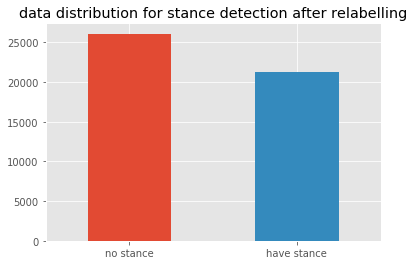

In [112]:
# data distribution after relabelling
stack1 = list(train_labels)
stack2 = list(test_labels)
stack = stack1 + stack2
labels = pd.DataFrame(stack)
labels.columns = ['label']
labels['label'].replace({-1:'no stance',1:'have stance'},inplace=True)
labels['label'].value_counts().plot.bar(rot=0)
plt.title('data distribution for stance detection after relabelling')
save_jpeg('../graphs','data distribution after relabelling')

### 4. Cutoff Analysis for speeches length

* check speech length distribution here

In [113]:
def cut_off_analysis_of_speech_length(min_cutoff,max_cutoff,train_corpus,test_corpus):
    '''
    divide speeches into 3 groups: 
    1. speeches whose length is less than or equals min_cutoff
    2. speeches whose length is more than max_cutoff
    3. speeches whose length is between the min_cutoff and the max_cutoff'''
    corpus =  train_corpus + test_corpus
    #length of short speeches, long speeches and speeches with normal length
    short_sentences = []
    long_sentences = []
    normal_sentences = []
    length = []
    #index of short and long sentences
    index_short_sentences = []
    index_long_sentences = []

    for i in tqdm(range(len(corpus))):
        li = word_tokenize(corpus[i])
        i_len = len(li)
        if i_len<min_cutoff:
            short_sentences.append(i_len)
            index_short_sentences.append(i)
        elif i_len>max_cutoff:
            long_sentences.append(i_len)
            index_long_sentences.append(i)
        else:
            normal_sentences.append(i_len)
    all_speeches = short_sentences + long_sentences + normal_sentences
    return all_speeches, normal_sentences, long_sentences, short_sentences, index_short_sentences, index_long_sentences

**small experiment 1:**

In [114]:
all_speeches_len, normal_s_len, long_s_len, short_s_len, idx_short_s, idx_long_s = cut_off_analysis_of_speech_length(5,1000,train_corpus,test_corpus)

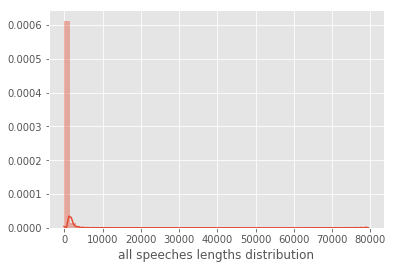

In [116]:
length = pd.Series(all_speeches_len)
sns.distplot(length,axlabel='all speeches lengths distribution') 
save_jpeg('../graphs','all_speeches_length_distribution')

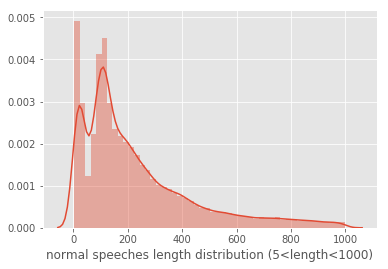

In [117]:
sns.distplot(normal_s_len,axlabel='normal speeches length distribution (5<length<1000)') 
save_jpeg('../graphs','speeches_with_normal_length_distribution (5<length<1000)')

**small experiment 2:**

In [119]:
all_speeches_len2, normal_s_len2, long_s_len2, short_s_len2, idx_short_s2, idx_long_s2 = cut_off_analysis_of_speech_length(10,1000,train_corpus,test_corpus)

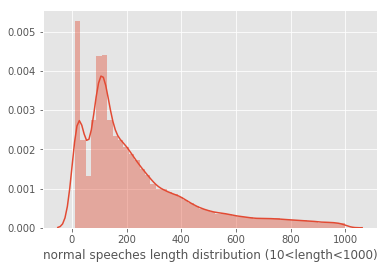

In [122]:
sns.distplot(normal_s_len2,axlabel='normal speeches length distribution (10<length<1000)') 
#save_jpeg('../graphs','speeches_with_normal_length_distribution')